In [4]:
'''
Focuses on app_train only
This notebook creates 20 (configurable number) polynomial features from the top columns agreed on by both 
peasons correlation coefficient and lgbm (via feature importances).
'''

In [50]:
# imports
from utils import * # contains auxillary and pre-processing methods
from models import * # contains methods for log_reg and lbgm with k-fold validation

In [51]:
# load pre-processed dataframes - If loading doesn't work then you'll need to creat the dataframes from the 
#pre-processing notebook 
train_data = load_pickle("../dataframes/app_train_preprocessed.pickle")
test_data = load_pickle("../dataframes/app_test_preprocessed.pickle")

# get train labels and test ids
train_Y = get_train_labels(train_data)
test_ids = test_data[['SK_ID_CURR']]

In [53]:
'''Run lgbm and save the feature importances'''
# need to drop TARGET and SK_ID_CURR   
train_X = train_data.drop(columns=['TARGET', 'SK_ID_CURR'],inplace=False)
test_X = test_data.drop(columns=['SK_ID_CURR'], inplace= False)

# convert from dataframes to arrays
train_X = train_X.values
test_X = test_X.values

feature_names = train_data.columns # required to create feature importances
model, predictions, feature_importances, metrics = gbm_basic(train_X, train_Y, test_X, feature_names, model_save_path=None, n_folds=5) # don't save model as save_path=None
# save_pickle("../misc/gbm_simple_feature_importances.pickle", feature_importances)

In [54]:
''' Return the top features determined by a lgbm model trained on the pre-processed app_train data'''
def get_top_gbm_features(path, num_feats):
    # get the names of the top n features for gbm 
    gbm_fi = load_pickle(path)
    top_feats =  gbm_fi.sort_values(by=["importance"], ascending=False)[:num_feats]['feature'].values
    return top_feats
    
top_gbm_feats = get_top_gbm_features("../misc/gbm_simple_feature_importances.pickle", 30)
print(top_gbm_feats)

['EXT_SOURCE_1' 'EXT_SOURCE_3' 'EXT_SOURCE_2' 'DAYS_BIRTH' 'AMT_CREDIT'
 'AMT_ANNUITY' 'DAYS_EMPLOYED' 'DAYS_ID_PUBLISH' 'AMT_GOODS_PRICE'
 'DAYS_LAST_PHONE_CHANGE' 'DAYS_REGISTRATION' 'REGION_POPULATION_RELATIVE'
 'AMT_INCOME_TOTAL' 'OWN_CAR_AGE' 'HOUR_APPR_PROCESS_START'
 'TOTALAREA_MODE' 'AMT_REQ_CREDIT_BUREAU_YEAR' 'BASEMENTAREA_MODE'
 'APARTMENTS_MODE' 'NAME_CONTRACT_TYPE' 'AMT_REQ_CREDIT_BUREAU_QRT'
 'LANDAREA_MODE' 'YEARS_BEGINEXPLUATATION_MODE'
 'NAME_EDUCATION_TYPE_Higher education' 'APARTMENTS_AVG' 'CODE_GENDER_F'
 'BASEMENTAREA_AVG' 'NONLIVINGAREA_AVG' 'LIVINGAREA_MODE'
 'OBS_30_CNT_SOCIAL_CIRCLE']


In [55]:
def get_sorted_correlations(df, feature):
    """
    Calculates the absolulte correlation score of every feature to the 'TARGET' column and returns the 
    correlations in descending order
    """
    correlations = df.corr()[feature]
    correlations = abs(correlations).sort_values(ascending=False)  # sort by correlation value (regardless if it's positive or negative)
    correlations = correlations.dropna()  # drop nans
    if 'TARGET' in correlations:
        correlations = correlations.drop(labels=[feature, 'TARGET'])  # remove corr to itself and target
    return correlations

def get_top_correlations(corrs, num_feats:int):
    """
    returns the top (num_feats) correlated columns given a correlation dataframe  
    """
    return corrs[:num_feats].keys()

# pcc_corrs = get_sorted_correlations(train_data, 'TARGET')
# save_pickle('../misc/target_corr_sorted_pcc.pickle', pcc_corrs)
pcc_corrs = load_pickle('../misc/target_corr_sorted_pcc.pickle') 
pcc_corrs = get_top_correlations(pcc_corrs, 30)
print(pcc_corrs)

Index(['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education',
       'DAYS_LAST_PHONE_CHANGE', 'CODE_GENDER_M', 'CODE_GENDER_F',
       'DAYS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY',
       'NAME_EDUCATION_TYPE_Secondary / secondary special',
       'NAME_INCOME_TYPE_Pensioner', 'ORGANIZATION_TYPE_XNA',
       'DAYS_EMPLOYED_ANOM', 'FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY',
       'FLAG_DOCUMENT_3', 'FLOORSMAX_AVG', 'FLOORSMAX_MEDI', 'FLOORSMAX_MODE',
       'OCCUPATION_TYPE_Laborers', 'EMERGENCYSTATE_MODE_No',
       'DAYS_REGISTRATION', 'HOUSETYPE_MODE_block of flats', 'AMT_GOODS_PRICE',
       'OWN_CAR_AGE'],
      dtype='object')


In [56]:
# get the top features agreed on by both pearsons correlation and lgbm
top_corr_feats = set(top_gbm_feats).intersection(set(pcc_corrs))
top_corr_feats = list(top_corr_feats)
len(top_corr_feats)

12

In [57]:
from sklearn.preprocessing import PolynomialFeatures

def create_poly_feats(df, poly_cols, degree):
    """
    Creates polynomial features from the columns given in the poly_cols list (up to a given degree) and returns a 
    dataframe containing the new polynomial features
    """
    # cols to create poly feature from
    selected_cols = df[poly_cols]
    # create polynomial features  to the given degree
    poly_transformer = PolynomialFeatures(degree=degree)
    poly_transformer.fit(selected_cols)
    poly_feats = poly_transformer.transform(selected_cols)
    
    # get the column names of the polynomial features
    col_names = poly_transformer.get_feature_names(poly_cols)
    poly_feats_df = pd.DataFrame(poly_feats, columns=col_names)
    poly_feats_df= poly_feats_df.drop(columns=['1']) #drop the constant column
    return poly_feats_df

def calc_poly_aic_score(feats_df, n=10):
    """
    Creates a dataframe mapping each feautre to its aic score and returns that along with the top n features with
    the highest aic scores
    """
    aic_scores = []
    # calculate the aic score for each of the poly features
    for col in feats_df:
        aic_scores.append(imputed_col_aic(feats_df, col))
    
    aic_df = pd.DataFrame({'col':feats_df.columns, 'aic':aic_scores}) 
    best_n_cols = get_top_aic_cols(aic_df, n)
    return aic_df, best_n_cols 

def get_top_aic_cols(df, n=10):
    # return the n features with the lowest aic score
    return df.sort_values(by='aic')[:n]['col'].values

# get the polynomial features for the training data
train_poly_df = create_poly_feats(train_data, top_corr_feats, 2)
train_poly_df['TARGET'] = train_data['TARGET'] # add Target col to train

# get the polynomial features for the testing
test_poly_df = create_poly_feats(test_data, top_corr_feats, 2)

# get the aic scores for each poly feature and the best features 
poly_aic_df, lowest_aic_cols = calc_poly_aic_score(train_poly_df, n=20)


Optimization terminated successfully.
         Current function value: 0.358709
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.328725
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.291889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.575244
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.279522
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.281536
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.305171
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403788
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.274594
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.320201
  

Optimization terminated successfully.
         Current function value: 0.304542
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.348135
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.283733
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.391971
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.382755
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.333927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.462483
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.366158
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.315926
         Iterations 7
         Current function value: 0.637190
         Iterations: 35


C:\Users\Bhumika\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [58]:
def merge_poly_feats(train_df, test_df, poly_train, poly_test):
    """
    Joins the polynomial features to the test and train dataframes
        - pass in original train and test dataframes and the dataframes for the poly features
    """
    # Merge polynomial features into training dataframe
    print("Before adding poly feats", train_df.shape, test_df.shape)
    poly_train['SK_ID_CURR'] = train_df['SK_ID_CURR']
    save_pickle("../dataframes/app_train_top_20_poly.pickle", train_poly) #save new train features
    
    poly_train = train_data.merge(poly_train, on = 'SK_ID_CURR', how = 'left')

    #  Merge polynomial features into testing dataframe
    poly_test['SK_ID_CURR'] = test_df['SK_ID_CURR']
    save_pickle("../dataframes/app_test_top_20_poly.pickle", test_poly)
    poly_test = test_data.merge(poly_test, on = 'SK_ID_CURR', how = 'left') #save new test features

    print("After adding poly feats:", poly_train.shape, poly_test.shape)
    return poly_train, poly_test

train_poly = train_poly_df[lowest_aic_cols] #top poly feature df
test_poly = test_poly_df[lowest_aic_cols] #top poly feature df

# save dataframes for pre-processed app train and test with top 20 polynomial features
# save_pickle("../dataframes/app_train_top_20_poly.pickle", train_poly)
# save_pickle("../dataframes/app_test_top_20_poly.pickle", test_poly)

train_poly, test_poly = merge_poly_feats(train_data, test_data, train_poly, test_poly)

# 'TARGET' should be the only extra feature in train_poly
assert set(train_poly.columns).difference(set(test_poly.columns)) == set(['TARGET']), "Only 'TARGET' should be the only extra feature in train_poly "



Before adding poly feats (307511, 232) (48744, 231)
File saved at  ../dataframes/app_train_top_20_poly.pickle
File saved at  ../dataframes/app_test_top_20_poly.pickle
After adding poly feats: (307511, 252) (48744, 251)


In [59]:
'''Prepare test and train data so it can be used for classifier models'''
# need to drop TARGET and SK_ID_CURR   
train_X = train_poly.drop(columns=['TARGET', 'SK_ID_CURR'],inplace=False)
feature_names = train_X.columns # required to create feature importances in gbm_basic
test_X = test_poly.drop(columns=['SK_ID_CURR'], inplace= False)

# convert from dataframes to arrays
train_X = train_X.values
test_X = test_X.values

print("Train {}, Test {}".format(train_X.shape, test_X.shape))

Train (307511, 250), Test (48744, 250)


Run 0 AUC socre: 0.7247492360207825
Run 1 AUC socre: 0.7154358771655939
Run 2 AUC socre: 0.7299488445579605
Run 3 AUC socre: 0.7238985009255494
Run 4 AUC socre: 0.7288758686328292
Avg ROC AUC score: 0.724581665460543


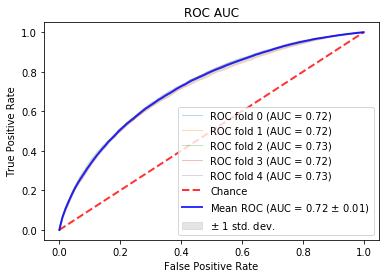

In [60]:
''' Create logistic regression classifier for baseline model, and score using ROC AUC '''
model, predictions = baseline_log_reg(train_X, train_Y, test_X, save_path=None, C=0.0001) # don't save model as save_path=None
cross_val_roc_curve(train_X, train_Y, model)
# create_and_save_submission(test_ids, predictions, "../test_predictions/filename.csv") # Add filename

Run 0 AUC socre: 0.7523544609927706
Run 1 AUC socre: 0.7547702730689548
Run 2 AUC socre: 0.7566502956356096
Run 3 AUC socre: 0.7555861545703987
Run 4 AUC socre: 0.756404137913517
Avg ROC AUC score: 0.7551530644362502


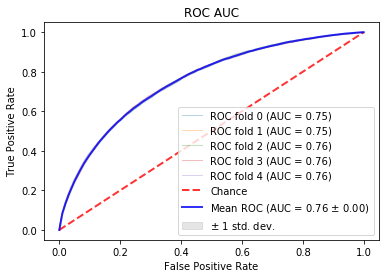

In [61]:
''' Create light gradient boosting machine (lgbm) classifier for baseline model, and score using ROC AUC '''

# NOTE : if this is very slow change n_estimators to 10 (will be much faster with scores of about 0.72)
model = lgb.LGBMClassifier(n_estimators=100, objective='binary',
                                   class_weight='balanced', learning_rate=0.05,
                                   reg_alpha=0.1, reg_lambda=0.1,
                                   subsample=0.8, n_jobs=-1, random_state=50)
cross_val_roc_curve(train_X, train_Y, model)
# create_and_save_submission(test_ids, predictions, "../test_predictions/filename.csv") # Add filename

In [48]:
''' Create a lgbm, and train using k-fold validation'''
# This model will take very long if cross_val_roc_curve(...) is used as the n_estimators is 1000 
model, predictions, feature_importances, metrics = gbm_basic(train_X, train_Y, test_X, feature_names, model_save_path=None, n_folds=5) # don't save model as save_path=None
# create_and_save_submission(test_ids, predictions, "../test_predictions/filename.csv") # Add filename
print(metrics)

Training Data Shape:  (307511, 250)
Testing Data Shape:  (48744, 250)
Training until validation scores don't improve for 100 rounds.
[200]	valid's binary_logloss: 0.563957	valid's auc: 0.753861	train's binary_logloss: 0.553428	train's auc: 0.798197
Early stopping, best iteration is:
[297]	valid's binary_logloss: 0.554718	valid's auc: 0.754071	train's binary_logloss: 0.539871	train's auc: 0.813942
Training until validation scores don't improve for 100 rounds.
[200]	valid's binary_logloss: 0.564053	valid's auc: 0.757156	train's binary_logloss: 0.553379	train's auc: 0.798331
Early stopping, best iteration is:
[223]	valid's binary_logloss: 0.561893	valid's auc: 0.757252	train's binary_logloss: 0.55013	train's auc: 0.802184
Training until validation scores don't improve for 100 rounds.
[200]	valid's binary_logloss: 0.563927	valid's auc: 0.762799	train's binary_logloss: 0.554372	train's auc: 0.797309
Early stopping, best iteration is:
[200]	valid's binary_logloss: 0.563927	valid's auc: 0.762

In [1]:
'''Running random search on a log reg model (to try tune it) - will take a while to run'''
model, preds = random_search_log_reg(train_X, train_Y, test_X, save_path=None)
create_and_save_submission(test_data, preds, save_path='../test_predictions/log_reg_tuned_poly_feats.csv')